# Homework 1: Deep Learning
Benjamin Devillers


---

This is the file `mp1.py`.

In [0]:
import matplotlib.pyplot as plt
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, Flatten, UpSampling2D, Concatenate

%matplotlib inline

Using TensorFlow backend.


In [0]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72
show_example = False

In [0]:
def generate_a_drawing(figsize, U, V, noise=0.0):

    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

if show_example:
    im = generate_a_rectangle(10, True)
    plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

    im = generate_a_disk(10)
    plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

    [im, v] = generate_a_triangle(20, False)
    plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False, verbose=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    if verbose: 
        print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0 and verbose:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification(free_location=True):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, free_location)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0, verbose=False):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    if verbose:
        print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0 and verbose:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)
    
    if ax is None:
        plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

We start by generating 2 sets:

- One for training,
- Another to test

In [0]:
X_train, Y_train = generate_dataset_classification(350, 20)
Y_train = to_categorical(Y_train, num_classes=3)

X_test, Y_test = generate_test_set_classification(False)

In [0]:
def show_img(im):
    plt.imshow(im.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

### Classification with SGD optimizer

Here we do a simple linear classifier.

It is composed of one Linear ("Dense") layer as well as a softmax activation function.

The softmax allows us to get a probability distribution as an output of our model, over the three classes.

We then use a mean squared error as a loss. Indeed, the density should have a 1 for the correct class and 0 otherwise (ex, `[0, 0, 1]` for a triangle).

In [0]:
classifier_sgd = Sequential([
    Dense(units=3, activation="softmax", input_dim=IMAGE_SIZE*IMAGE_SIZE)
])

classifier_sgd.compile(loss='mean_squared_error',
                       optimizer='sgd',
                       metrics=['accuracy'])

In [0]:
print("Training")

classifier_sgd.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.1)
loss_train, acc_train = classifier_sgd.evaluate(X_train, Y_train, batch_size=32)
print("Loss", loss_train, "Acc", acc_train)

print("Test")

loss_test, acc_test = classifier_sgd.evaluate(X_test, Y_test, batch_size=32)
print("Loss", loss_test, "Acc", acc_test)

Training
Train on 270 samples, validate on 30 samples
Epoch 1/20
270/270 [==============================] - 0s 660us/step - loss: 0.2935 - acc: 0.3556 - val_loss: 0.4079 - val_acc: 0.3333
Epoch 2/20
270/270 [==============================] - 0s 167us/step - loss: 0.2722 - acc: 0.4778 - val_loss: 0.2265 - val_acc: 0.3333
Epoch 3/20
270/270 [==============================] - 0s 158us/step - loss: 0.2427 - acc: 0.4667 - val_loss: 0.2133 - val_acc: 0.5667
Epoch 4/20
270/270 [==============================] - 0s 162us/step - loss: 0.2467 - acc: 0.5407 - val_loss: 0.1557 - val_acc: 0.6667
Epoch 5/20
270/270 [==============================] - 0s 178us/step - loss: 0.1680 - acc: 0.6259 - val_loss: 0.1476 - val_acc: 0.6000
Epoch 6/20
270/270 [==============================] - 0s 170us/step - loss: 0.2012 - acc: 0.5704 - val_loss: 0.1286 - val_acc: 0.7333
Epoch 7/20
270/270 [==============================] - 0s 161us/step - loss: 0.1555 - acc: 0.6667 - val_loss: 0.1707 - val_acc: 0.6333
Epoch 8/

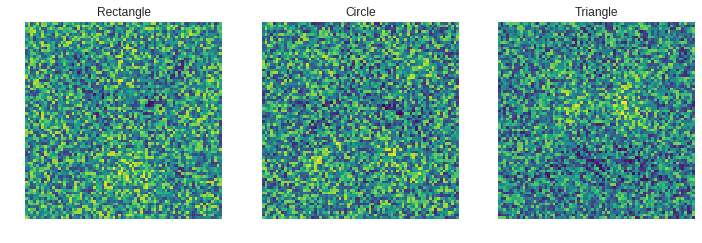

In [0]:
def visualize_first_layer(model):
    weights = model.get_weights()[0]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    titles = ['Rectangle', 'Circle', 'Triangle']
    for k in range(3):
        axes[k].imshow(weights[:, k].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap="viridis")
        axes[k].set_title(titles[k])
        axes[k].grid('off')
        axes[k].axis('off')
    plt.show()

visualize_first_layer(classifier_sgd)

### Classification with Adam optimizer

We now do the exact same thing with the Adam optimization method.

In [0]:
classifier_adam = Sequential([
    Dense(units=3, activation="softmax", input_dim=IMAGE_SIZE*IMAGE_SIZE)
])

classifier_adam.compile(loss='mean_squared_error',
                        optimizer='adam',
                        metrics=['accuracy'])

In [0]:
print("Training")

classifier_adam.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split=0.1)
loss_train, acc_train = classifier_adam.evaluate(X_train, Y_train, batch_size=32)
print("Loss", loss_train, "Acc", acc_train)

print("Test")

loss_test, acc_test = classifier_adam.evaluate(X_test, Y_test, batch_size=32)
print("Loss", loss_val, "Acc", acc_val)

Training
Train on 270 samples, validate on 30 samples
Epoch 1/20
270/270 [==============================] - 0s 728us/step - loss: 0.3284 - acc: 0.3333 - val_loss: 0.2888 - val_acc: 0.3667
Epoch 2/20
270/270 [==============================] - 0s 157us/step - loss: 0.3023 - acc: 0.3593 - val_loss: 0.2592 - val_acc: 0.4333
Epoch 3/20
270/270 [==============================] - 0s 162us/step - loss: 0.2625 - acc: 0.4667 - val_loss: 0.2663 - val_acc: 0.4000
Epoch 4/20
270/270 [==============================] - 0s 158us/step - loss: 0.2586 - acc: 0.4889 - val_loss: 0.2421 - val_acc: 0.5000
Epoch 5/20
270/270 [==============================] - 0s 170us/step - loss: 0.2479 - acc: 0.5222 - val_loss: 0.2272 - val_acc: 0.5667
Epoch 6/20
270/270 [==============================] - 0s 158us/step - loss: 0.2245 - acc: 0.6037 - val_loss: 0.2176 - val_acc: 0.6000
Epoch 7/20
270/270 [==============================] - 0s 165us/step - loss: 0.2160 - acc: 0.6259 - val_loss: 0.2120 - val_acc: 0.6000
Epoch 8/

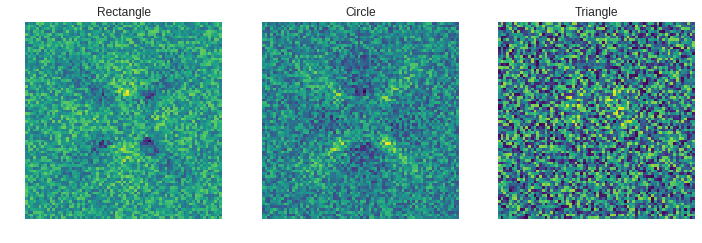

In [0]:
visualize_first_layer(classifier_adam)

## A more difficult problem classification problem

In [0]:
X_train, Y_train = generate_dataset_classification(350, 20, True)
Y_train = to_categorical(Y_train, num_classes=3)

X_test, Y_test = generate_test_set_classification()

In [0]:
classifier_adam.compile(loss='categorical_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

In [0]:
print("Training")

classifier_adam.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split=0.1)
loss_train, acc_train = classifier_adam.evaluate(X_train, Y_train, batch_size=64)
print("Loss", loss_train, "Acc", acc_train)

print("Test")

loss_test, acc_test = classifier_adam.evaluate(X_test, Y_test, batch_size=64)
print("Loss", loss_test, "Acc", acc_test)

Training
Train on 270 samples, validate on 30 samples
Epoch 1/20
270/270 [==============================] - 0s 826us/step - loss: 7.3241 - acc: 0.2963 - val_loss: 6.1413 - val_acc: 0.4333
Epoch 2/20
270/270 [==============================] - 0s 133us/step - loss: 7.4832 - acc: 0.2852 - val_loss: 6.0660 - val_acc: 0.2667
Epoch 3/20
270/270 [==============================] - 0s 124us/step - loss: 7.2104 - acc: 0.3185 - val_loss: 5.4337 - val_acc: 0.3000
Epoch 4/20
270/270 [==============================] - 0s 125us/step - loss: 7.0767 - acc: 0.3259 - val_loss: 5.4250 - val_acc: 0.3667
Epoch 5/20
270/270 [==============================] - 0s 129us/step - loss: 7.0703 - acc: 0.2667 - val_loss: 5.6049 - val_acc: 0.3667
Epoch 6/20
270/270 [==============================] - 0s 134us/step - loss: 6.9785 - acc: 0.3778 - val_loss: 5.4199 - val_acc: 0.4333
Epoch 7/20
270/270 [==============================] - 0s 133us/step - loss: 6.8800 - acc: 0.3000 - val_loss: 5.4521 - val_acc: 0.3667
Epoch 8/

If the images are allowed to move, we get a bit more than random accuracy (1/3 because there are 3 classes). 
We see that the classifier overfits on the data (training accuracy decreased) to minimize the loss.

Indeed, we cannot linearly separate between the classes if the shapes are allowed to move: one pixel is not necessarily activated for all the images of one class.

To solve this problem, we add a convolution layer that will look for certain features of the image independantly of its location.

#### With a convolution layer

In [0]:
classifier_conv = Sequential([
    Conv2D(16, kernel_size=5, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=3, activation="softmax")
])

classifier_conv.compile(loss='mean_squared_error',
                        optimizer='adam',
                        metrics=['accuracy'])

We need to reshape the input as an image to keep the positional information.

In [0]:
X_train_conv = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
X_train_conv = np.expand_dims(X_train_conv, axis=3)  # We add a dimension for the channel
X_test_conv = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
X_test_conv = np.expand_dims(X_test_conv, axis=3)

In [0]:
X_train_conv.shape

(300, 72, 72, 1)

In [0]:
print("Training")

classifier_conv.fit(X_train_conv, Y_train, epochs=20, batch_size=64, validation_split=0.1)
loss_train, acc_train = classifier_conv.evaluate(X_train_conv, Y_train, batch_size=64)
print("Loss", loss_train, "Acc", acc_train)

print("Test")

loss_test, acc_test = classifier_conv.evaluate(X_test_conv, Y_test, batch_size=64)
print("Loss", loss_val, "Acc", acc_val)

Training
Train on 270 samples, validate on 30 samples
Epoch 1/20
270/270 [==============================] - 2s 8ms/step - loss: 0.3257 - acc: 0.3185 - val_loss: 0.4385 - val_acc: 0.3000
Epoch 2/20
270/270 [==============================] - 0s 215us/step - loss: 0.3319 - acc: 0.3556 - val_loss: 0.3086 - val_acc: 0.4333
Epoch 3/20
270/270 [==============================] - 0s 225us/step - loss: 0.2659 - acc: 0.4296 - val_loss: 0.3038 - val_acc: 0.4333
Epoch 4/20
270/270 [==============================] - 0s 204us/step - loss: 0.2572 - acc: 0.4185 - val_loss: 0.2939 - val_acc: 0.3000
Epoch 5/20
270/270 [==============================] - 0s 209us/step - loss: 0.2250 - acc: 0.4037 - val_loss: 0.2108 - val_acc: 0.3333
Epoch 6/20
270/270 [==============================] - 0s 208us/step - loss: 0.1841 - acc: 0.6741 - val_loss: 0.1920 - val_acc: 0.6333
Epoch 7/20
270/270 [==============================] - 0s 204us/step - loss: 0.1668 - acc: 0.7667 - val_loss: 0.1721 - val_acc: 0.7000
Epoch 8/20

Let's now visualize the 16 $5\times5$ filters of our Conv2D layer.

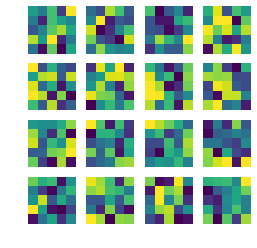

In [0]:
conv_weights = classifier_conv.get_weights()[0].squeeze()
fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i in range(4):
    for j in range(4):
        axes[i, j].grid('off')
        axes[i, j].axis('off')
        axes[i, j].imshow(conv_weights[:, :, 4 * i + j], cmap="viridis")
plt.show()

## A regression problem

For this problem, we only get triangles. However, the position of the triangle varies, so we will need to account for this.

The goal of this problem is to find a bounding box (or rather a bounding triangle in this case). We therefore need to predict 3 points which represent the corners of the triangles.

As the triangles are randomly generated, we first need to order the targets so that the corners always appear in the same order. We will choose as an arbitrary order: left corners before right corners, and if same x coordinate, top comes before bottom.

Our model will comprise:

- 4 convolutional layers
- 2 dense layers with ReLU activation

In [0]:
X_train, Y_train = generate_dataset_regression(1500, 20)

X_test, Y_test = generate_test_set_regression()

In [0]:
class PointOrderClockwise:
    def __init__(self, x, y):
        norm = np.sqrt(x*x + y*y)
        self.x = x / norm
        self.y = y / norm
    
    def __lt__(self, other):
        dot = self.x * other.x + self.y * other.y
        det = self.x * other.y - self.y * other.x
        angle = np.arctan2(det, dot)
        return angle <= 0


def dist(x1, x2):
    return np.sqrt((x1[0] - x2[0])**2 + (x1[1] - x2[1])**2)
    

def normalize_edge_length(points):
    lengths = [dist(points[i], points[(i+1)%3]) + 
               dist(points[i-1], points[i]) for i in range(3)]
    order = np.argsort(lengths)
    return points[order]


def normalize_clockwise(points):
    return sorted(points, key=lambda p: PointOrderClockwise(p[0], p[1]))


def normalize_left_right(points):
    return sorted(points, key=lambda p: p[0])

    
def normalize_targets_vertices(targets, normalization):
    final_targets = np.zeros_like(targets)
    for k in range(targets.shape[0]):
        points = np.array([(targets[k, i], 
                            targets[k, i+1]) for i in range(0, 6, 2)])
        order = normalization(points)
        final_targets[k] = np.array([order[0][0], order[0][1], order[1][0], 
                                     order[1][1], order[2][0], order[2][1]])
    return final_targets
        

Y_train_left_right = normalize_targets_vertices(Y_train, normalize_left_right)
Y_test_left_right = normalize_targets_vertices(Y_test, normalize_left_right)

Y_train_clockwise = normalize_targets_vertices(Y_train, normalize_clockwise)
Y_test_clockwise = normalize_targets_vertices(Y_test, normalize_clockwise)

Y_train_edge_length = normalize_targets_vertices(Y_train, normalize_edge_length)
Y_test_edge_length = normalize_targets_vertices(Y_test, normalize_edge_length)

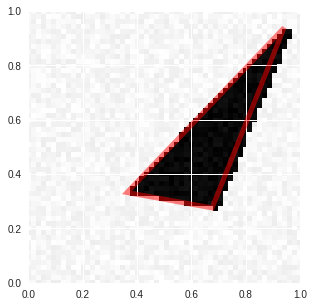

In [0]:
i = 0
visualize_prediction(X_test[i], Y_test[i])

In [0]:
X_train = X_train.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
X_test = X_test.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)

X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

In [0]:
regression = Sequential([
    Conv2D(16, kernel_size=3, activation="relu", input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(32, kernel_size=3, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(16, kernel_size=3, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(8, kernel_size=3, activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=200, activation="relu"),
    Dropout(0.5),
    Dense(units=6, activation="relu")
])


regression.compile(loss="mean_squared_error",
                   optimizer='adam')

regression.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 70, 70, 16)        160       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 8, 8, 16)          4624      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 2, 2, 8)           1160      
__________

### Left-right order
We first order the points of the triangle by the x-axis.

In [0]:
print("Training")

regression.fit(X_train, Y_train_left_right, epochs=30, batch_size=32, validation_split=0.1)
loss_train = regression.evaluate(X_train, Y_train_left_right, batch_size=32)
print("Loss", loss_train)

print("Validation")

loss_test = regression.evaluate(X_test, Y_test_left_right, batch_size=32)
print("Loss", loss_val)

Training
Train on 1350 samples, validate on 150 samples
Epoch 1/30
1350/1350 [==============================] - 2s 1ms/step - loss: 0.1428 - val_loss: 0.0608
Epoch 2/30
1350/1350 [==============================] - 1s 416us/step - loss: 0.0718 - val_loss: 0.0528
Epoch 3/30
1350/1350 [==============================] - 1s 418us/step - loss: 0.0605 - val_loss: 0.0453
Epoch 4/30
1350/1350 [==============================] - 1s 415us/step - loss: 0.0517 - val_loss: 0.0393
Epoch 5/30
1350/1350 [==============================] - 1s 429us/step - loss: 0.0460 - val_loss: 0.0333
Epoch 6/30
1350/1350 [==============================] - 1s 428us/step - loss: 0.0402 - val_loss: 0.0316
Epoch 7/30
1350/1350 [==============================] - 1s 417us/step - loss: 0.0375 - val_loss: 0.0304
Epoch 8/30
1350/1350 [==============================] - 1s 417us/step - loss: 0.0341 - val_loss: 0.0262
Epoch 9/30
1350/1350 [==============================] - 1s 422us/step - loss: 0.0319 - val_loss: 0.0257
Epoch 10/3

In [0]:
Y_test_predicted = regression.predict(X_test)

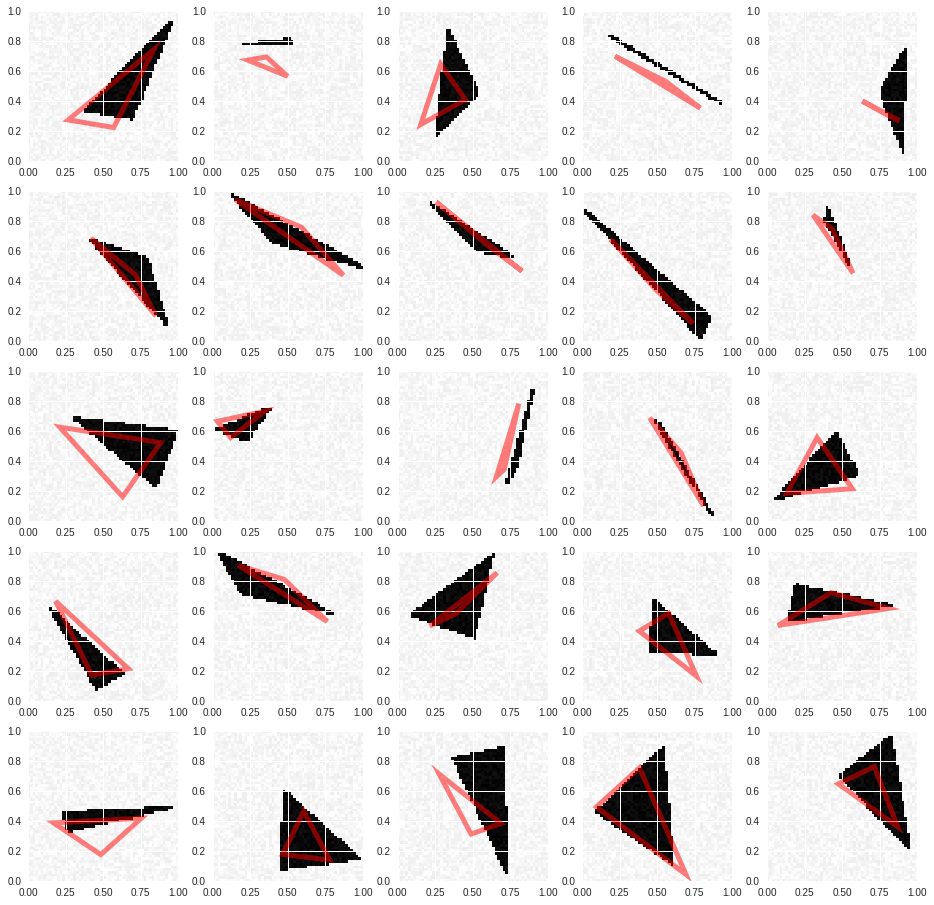

In [0]:
def show_triangles_regression(X, Y):
    k = 0
    n_subplots = 5
    fig, axes = plt.subplots(n_subplots, n_subplots, figsize=(16, 16))
    for i in range(n_subplots):
        for j in range(n_subplots):
            visualize_prediction(X[k], Y[k], axes[i][j])
            k += 1
    plt.show()

show_triangles_regression(X_test, Y_test_predicted)

### Clockwise order

Going from the center of the image we order the vertices using a clockwise order.

In [0]:
regression.compile(loss="mean_squared_error",
                   optimizer='adam')

regression.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 70, 70, 16)        160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 16)          4624      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 2, 8)           1160      
__________

In [0]:
print("Training")

regression.fit(X_train, Y_train_clockwise, epochs=30, batch_size=32, validation_split=0.1)
loss_train = regression.evaluate(X_train, Y_train_clockwise, batch_size=32)
print("Loss", loss_train)

print("Validation")

loss_test = regression.evaluate(X_test, Y_test_clockwise, batch_size=32)
print("Loss", loss_val)

Training
Train on 1350 samples, validate on 150 samples
Epoch 1/30
1350/1350 [==============================] - 1s 913us/step - loss: 0.0360 - val_loss: 0.0253
Epoch 2/30
1350/1350 [==============================] - 1s 402us/step - loss: 0.0256 - val_loss: 0.0221
Epoch 3/30
1350/1350 [==============================] - 1s 420us/step - loss: 0.0239 - val_loss: 0.0210
Epoch 4/30
1350/1350 [==============================] - 1s 427us/step - loss: 0.0223 - val_loss: 0.0207
Epoch 5/30
1350/1350 [==============================] - 1s 408us/step - loss: 0.0211 - val_loss: 0.0191
Epoch 6/30
1350/1350 [==============================] - 1s 427us/step - loss: 0.0196 - val_loss: 0.0181
Epoch 7/30
1350/1350 [==============================] - 1s 407us/step - loss: 0.0185 - val_loss: 0.0179
Epoch 8/30
1350/1350 [==============================] - 1s 420us/step - loss: 0.0178 - val_loss: 0.0177
Epoch 9/30
1350/1350 [==============================] - 1s 424us/step - loss: 0.0174 - val_loss: 0.0166
Epoch 10

In [0]:
Y_test_predicted = regression.predict(X_test)

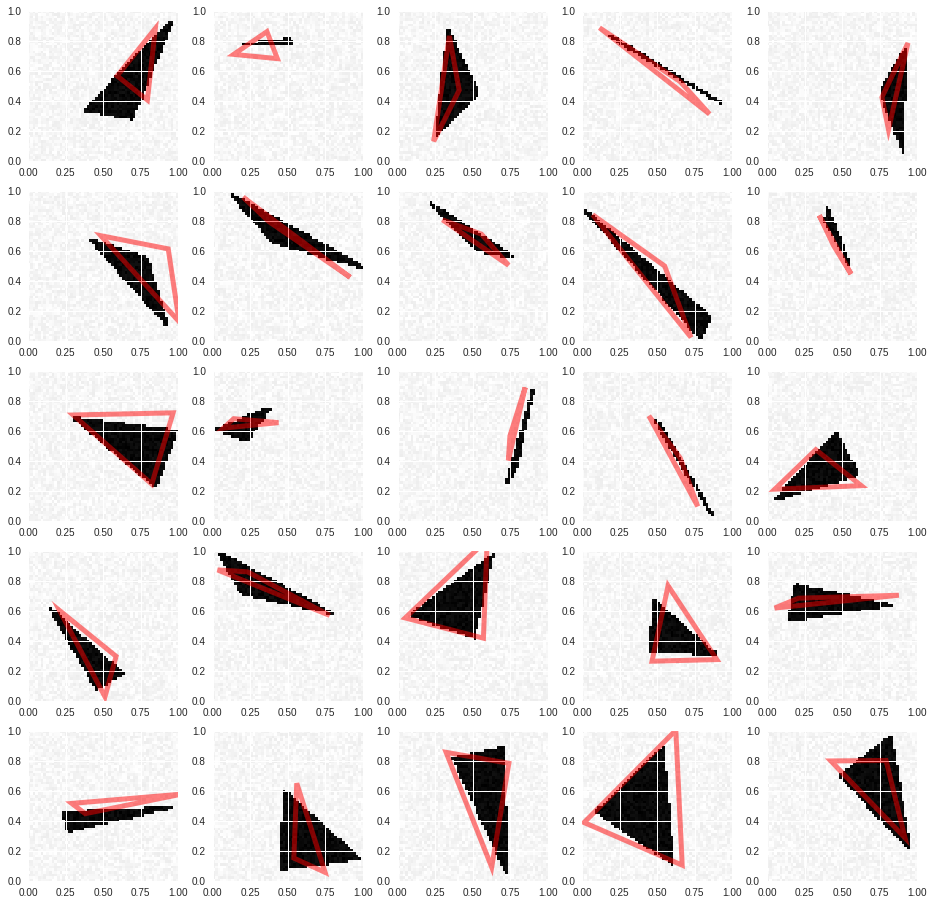

In [0]:
show_triangles_regression(X_test, Y_test_predicted)

### Using the length of the edges

We say that the corner $c_1 \le c_2$ if the sum of the length of the 2 edges of $c_1$ is lower than the one of $c_2$.

In [0]:
regression.compile(loss="mean_squared_error",
                   optimizer='adam')

regression.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 70, 70, 16)        160       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 23, 16)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 21, 21, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 16)          4624      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 16)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 2, 2, 8)           1160      
__________

In [0]:
print("Training")

regression.fit(X_train, Y_train_edge_length, epochs=30, batch_size=32, validation_split=0.1)
loss_train = regression.evaluate(X_train, Y_train_edge_length, batch_size=32)
print("Loss", loss_train)

print("Validation")

loss_test = regression.evaluate(X_test, Y_test_edge_length, batch_size=32)
print("Loss", loss_val)

Training
Train on 1350 samples, validate on 150 samples
Epoch 1/30
1350/1350 [==============================] - 1s 951us/step - loss: 0.0635 - val_loss: 0.0558
Epoch 2/30
1350/1350 [==============================] - 1s 399us/step - loss: 0.0544 - val_loss: 0.0527
Epoch 3/30
1350/1350 [==============================] - 1s 419us/step - loss: 0.0511 - val_loss: 0.0503
Epoch 4/30
1350/1350 [==============================] - 1s 434us/step - loss: 0.0465 - val_loss: 0.0469
Epoch 5/30
1350/1350 [==============================] - 1s 427us/step - loss: 0.0425 - val_loss: 0.0434
Epoch 6/30
1350/1350 [==============================] - 1s 432us/step - loss: 0.0396 - val_loss: 0.0427
Epoch 7/30
1350/1350 [==============================] - 1s 428us/step - loss: 0.0368 - val_loss: 0.0411
Epoch 8/30
1350/1350 [==============================] - 1s 435us/step - loss: 0.0333 - val_loss: 0.0415
Epoch 9/30
1350/1350 [==============================] - 1s 434us/step - loss: 0.0324 - val_loss: 0.0414
Epoch 10

In [0]:
Y_test_predicted = regression.predict(X_test)

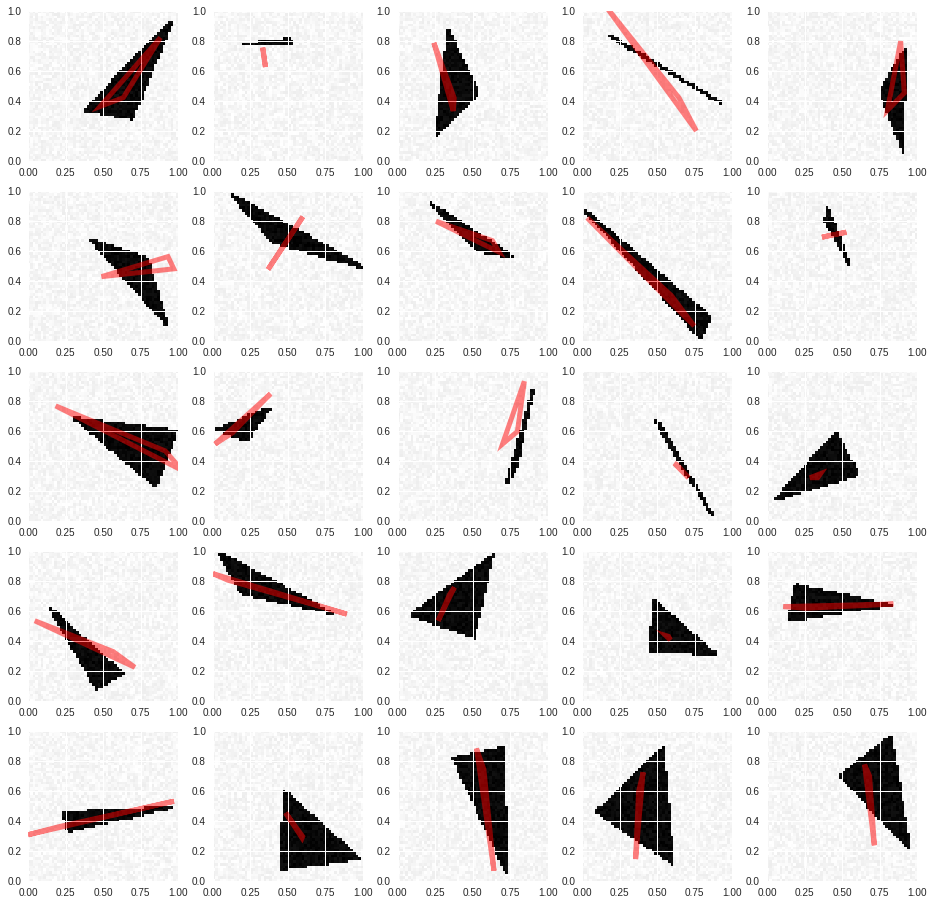

In [0]:
show_triangles_regression(X_test, Y_test_predicted)

### Conclusion
According to those results, a clockwise ordering gives the best regression.

## Denoising

We start by redefining the method generation functions to output the noisy image as well as the noise free image.

In [0]:
def generate_a_drawing(figsize, U, V, noise=0.0):

    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noise, imdata


def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return generate_a_drawing(figsize, U, V, noise)


def generate_dataset_denoising(nb_samples, noise=0.0, free_location=True, verbose=False, seed=None):
    if seed is not None:      
        np.random.seed(42)
    # Getting im_size:
    im_size = generate_a_rectangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    if verbose: 
        print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0 and verbose:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i], Y[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i], Y[i] = generate_a_disk(noise, free_location)
        else:
            X[i], Y[i] = generate_a_triangle(noise, free_location)
    X = (X + noise) / (255 + 2 * noise)
    Y = Y / 255
    X = X.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
    X = np.expand_dims(X, axis=4)
    Y = Y.reshape(-1, IMAGE_SIZE, IMAGE_SIZE)
    Y = np.expand_dims(Y, axis=4)
    return [X, Y]

In [0]:
X_train, Y_train = generate_dataset_denoising(300, 200)
X_test, Y_test = generate_dataset_denoising(300, 255, seed=42)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [0]:
print(X_train[0].shape)
print(Y_train[0].shape)

(72, 72, 1)
(72, 72, 1)


### Hourglass architecture

Here, we implement a smaller version of u-net with smaller kernels.

In [0]:
inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))
conv1a = Conv2D(16, 3, activation='relu', padding = 'same')(inputs)
conv1b = Conv2D(16, 3, activation='relu', padding = 'same')(conv1a)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1b)

conv2a = Conv2D(32, 3, activation='relu', padding = 'same')(pool1)
conv2b = Conv2D(32, 3, activation='relu', padding = 'same')(conv2a)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2b)

conv3a = Conv2D(64, 3, activation='relu', padding = 'same')(pool2)
conv3b = Conv2D(64, 3, activation='relu', padding = 'same')(conv3a)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3b)

up4 = UpSampling2D(size=(2, 2))(pool3)
up_conv4 = Conv2D(64, 2, activation='relu', padding = 'same')(up4)
conv4b = Conv2D(64, 3, activation='relu', padding = 'same')(up_conv4)
conv4c = Conv2D(64, 3, activation='relu', padding = 'same')(conv4b)

up5 = UpSampling2D(size=(2, 2))(conv4c)
up_conv5 = Conv2D(32, 2, activation='relu', padding = 'same')(up5)
merge5 = Concatenate(axis=3)([conv2b, up_conv5])
conv5b = Conv2D(32, 3, activation='relu', padding = 'same')(merge5)
conv5c = Conv2D(32, 3, activation='relu', padding = 'same')(conv5b)

up6 = UpSampling2D(size=(2, 2))(conv5c)
up_conv6 = Conv2D(64, 2, activation='relu', padding = 'same')(up6)
merge6 = Concatenate(axis=3)([conv1b, up_conv6])
conv6b = Conv2D(64, 3, activation='relu', padding = 'same')(merge6)
conv6c = Conv2D(64, 3, activation='relu', padding = 'same')(conv6b)
    
conv7 = Conv2D(1, 1, activation="sigmoid")(conv6c)

model = Model(input=inputs, output=conv7)
    
model.compile(loss='binary_crossentropy',
              optimizer='adam')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
print("Training")
model.fit(X_train, Y_train, epochs=20, batch_size=64, validation_split=0.1)
loss_train = model.evaluate(X_train, Y_train, batch_size=64)
print("Loss", loss_train)

print("Test")
loss_test = model.evaluate(X_test, Y_test, batch_size=64)
print("Loss", loss_test)

Training
Train on 270 samples, validate on 30 samples
Epoch 1/20
270/270 [==============================] - 2s 8ms/step - loss: 0.5732 - val_loss: 0.5575
Epoch 2/20
270/270 [==============================] - 1s 3ms/step - loss: 0.4034 - val_loss: 0.3059
Epoch 3/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2917 - val_loss: 0.2454
Epoch 4/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2563 - val_loss: 0.2284
Epoch 5/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2346 - val_loss: 0.2007
Epoch 6/20
270/270 [==============================] - 1s 3ms/step - loss: 0.2042 - val_loss: 0.1704
Epoch 7/20
270/270 [==============================] - 1s 3ms/step - loss: 0.1660 - val_loss: 0.1269
Epoch 8/20
270/270 [==============================] - 1s 3ms/step - loss: 0.1217 - val_loss: 0.0974
Epoch 9/20
270/270 [==============================] - 1s 3ms/step - loss: 0.0950 - val_loss: 0.0791
Epoch 10/20
270/270 [=========================

In [0]:
Y_test_predicted = model.predict(X_test)

Let's now look at the results on our test set

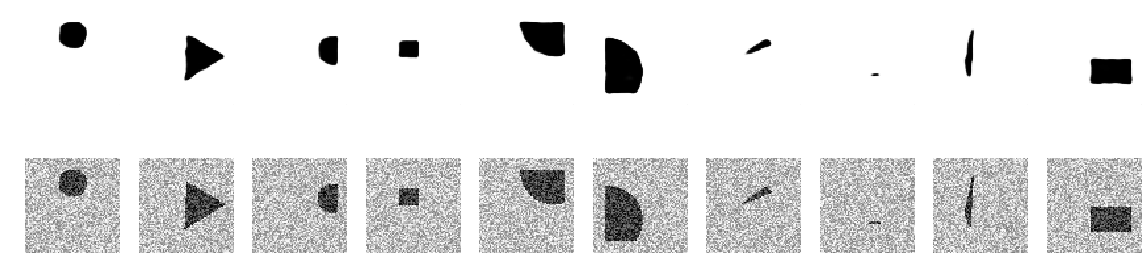

In [0]:
def show_denoised(X, Y):
    k = 0
    n_subplots = 10
    fig, axes = plt.subplots(2, n_subplots, figsize=(20, 5))
    for i in range(n_subplots):
        axes[0][i].imshow(Y_test_predicted[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
        axes[1][i].imshow(X_test[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
        axes[0][i].grid('off')
        axes[1][i].grid('off')
        axes[0][i].axis('off')
        axes[1][i].axis('off')
        k += 1
    plt.show()

show_denoised(X_test, Y_test_predicted)